In [2]:
#!pip3 install torch torchvision pypianoroll matplotlib tqdm livelossplot gdown

#torch matplotlib tqdm livelossplot gdown "pypianoroll>=1.0.2"

from IPython.display import clear_output
#from ipywidgets import interact, IntSlider

import os, os.path, shutil
import zipfile
import random
import json
import pickle
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import pypianoroll
import pretty_midi
from pypianoroll import Multitrack, Track
from tqdm import tqdm
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot



#import itertools
#import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec
#import moviepy.editor as mpy
#import music21
#from IPython import display
#import seaborn as sns

#from google.colab import drive

#drive.mount('/content/drive', force_remount=True)

c:\Users\lwgmi\anaconda3\envs\proj_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Data
n_tracks = 4  # number of tracks
n_pitches = 83  # number of pitches
lowest_pitch = 24  # MIDI note number of the lowest pitch
n_samples_per_song = 4  # number of samples to extract from each song in the datset
n_measures = 4  # number of measures per sample
beat_resolution = 4  # temporal resolution of a beat (in timestep)
programs = [0, 0, 0, 0]  # program number for each track
is_drums = [False, False, False, False]  # drum indicator for each track
track_names = ['Soprano', 'Alto', 'Tenor', 'Bass']  # name of each track
tempo = 100

measure_resolution = 4 * beat_resolution
tempo_array = np.full((4 * 4 * measure_resolution, 1), tempo)

# Training
batch_size = 64
latent_dim = 128
n_steps = 1000

# Sampling
sample_interval = 10  # interval to run the sampler (in step)
n_samples = 4

#Directories
!mkdir midiDataset

A subdirectory or file midiDataset already exists.


In [4]:
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in 'c:\\Users\\lwgmi\\Documents\\GitHub\\HonoursProject-reharmonisationGAN': ['-p', '.git', '.gitignore', '.ipynb_checkpoints', 'Dataset', 'LICENSE', 'midiDataset', 'README.md', 'ReharmonisationGAN.ipynb', 'test.mid']


In [5]:
"""Midi dataset."""

from typing import Tuple
from torch import Tensor

#import torch
from torch import nn
from torch.utils.data import Dataset

#import numpy as np
from music21 import midi
from music21 import converter
from music21 import note, stream, duration, tempo


class MidiDataset(Dataset):
    """MidiDataset.
    Parameters
    ----------
    path: str
        Path to dataset.
    split: str, optional (default="train")
        Split of dataset.
    n_bars: int, optional (default=2)
        Number of bars.
    n_steps_per_bar: int, optional (default=16)
        Number of steps per bar.
    """

    def __init__(
        self,
        path: str,
        split: str = "train",
        n_bars: int = 8,
        n_steps_per_bar: int = 16,
    ) -> None:
        """Initialize."""
        self.n_bars = n_bars
        self.n_steps_per_bar = n_steps_per_bar
        dataset = np.load(path, allow_pickle=True, encoding="bytes")[split]
        self.data_binary, self.data_ints, self.data = self.__preprocess__(dataset)

    def __len__(self) -> int:
        """Return the number of samples in dataset."""
        return len(self.data_binary)

    def __getitem__(self, index: int) -> Tensor:
        """Return one samples from dataset.
        Parameters
        ----------
        index: int
            Index of sample.
        Returns
        -------
        Tensor:
            Sample.
        """
        return torch.from_numpy(self.data_binary[index]).float()

    def __preprocess__(self, data: np.ndarray) -> Tuple[np.ndarray]:
        """Preprocess data.
        Parameters
        ----------
        data: np.ndarray
            Data.
        Returns
        -------
        Tuple[np.ndarray]:
            Data binary, data ints, preprocessed data.
        """
        data_ints = []
        for x in data:
            skip = True
            skip_rows = 0
            while skip:
                if not np.any(np.isnan(x[skip_rows: skip_rows + 4])):
                    skip = False
                else:
                    skip_rows += 4
            #print(x.shape)
            if self.n_bars * self.n_steps_per_bar < x.shape[0]:
                data_ints.append(x[skip_rows: self.n_bars * self.n_steps_per_bar + skip_rows, :])
        
        data_ints = np.array(data_ints)

        #print(data_ints.shape)
        self.n_songs = data_ints.shape[0]
        self.n_tracks = data_ints.shape[2]
        data_ints = data_ints.reshape([self.n_songs, self.n_bars * self.n_steps_per_bar, self.n_tracks])
        #print(data_ints.shape)
        max_note = n_pitches
        mask = np.isnan(data_ints)
        data_ints[mask] = max_note + 1
        max_note = max_note + 1
        data_ints = data_ints.astype(int)
        #print(data_ints.shape)
        
        num_classes = max_note + 1
        data_binary = np.eye(num_classes)[data_ints]
        data_binary[data_binary == 0] = -1
        data_binary = np.delete(data_binary, max_note, -1)
        data_binary = data_binary.transpose([0, 1, 3, 2])
        #print(data_binary.shape)
        return data_binary, data_ints, data


def binarise_output(output: np.ndarray) -> np.ndarray:
    """Binarize output.
    Parameters
    ----------
    output: np.ndarray
        Output array.
    """
    max_pitches = np.argmax(output, axis=-1)
    return max_pitches


def postprocess(
    output: np.ndarray,
    n_tracks: int = 4,
    n_bars: int = 8,
    n_steps_per_bar: int = 16,
) -> stream.Score:
    """Postprocess output.
    Parameters
    ----------
    output: np.ndarray
        Output array.
    n_tracks: int, (default=4)
        Number of tracks.
    n_bars: int, (default=2)
        Number of bars.
    n_steps_per_bar: int, (default=16)
        Number of steps per bar.
    """
    parts = stream.Score()
    parts.append(tempo.MetronomeMark(number=66))
    max_pitches = binarise_output(output)
    midi_note_score = np.vstack([
        max_pitches[i].reshape([n_bars * n_steps_per_bar, n_tracks]) for i in range(len(output))
    ])
    for i in range(n_tracks):
        last_x = int(midi_note_score[:, i][0])
        s = stream.Part()
        dur = 0
        for idx, x in enumerate(midi_note_score[:, i]):
            x = int(x)
            if (x != last_x or idx % 4 == 0) and idx > 0:
                n = note.Note(last_x)
                n.duration = duration.Duration(dur)
                s.append(n)
                dur = 0
            last_x = x
            dur = dur + 0.25
        n = note.Note(last_x)
        n.duration = duration.Duration(dur)
        s.append(n)
        parts.append(s)
    #print(parts)
    return parts

In [6]:
from pypianoroll.track import BinaryTrack
def save_pianoroll_as_midi(dataset,
                  programs=programs,
                  track_names=track_names,
                  is_drums=is_drums,
                  tempo=tempo,           # in bpm
                  beat_resolution=beat_resolution,  # number of time steps
                  destination_path="/content/midiDataset/"
                  ):
    data_ = []
    sopData = []

    for piece in dataset:

      pianoroll = piece > 0

      #print(pianoroll.shape)

    # Reshape batched pianoroll array to a single pianoroll array
      pianoroll_ = pianoroll.reshape((-1, pianoroll.shape[1], pianoroll.shape[2]))

      #print(pianoroll_.shape)

    # Create the tracks   
      tracks = []
      for idx in range(pianoroll_.shape[2]):
          tracks.append(pypianoroll.BinaryTrack(
            track_names[idx], programs[idx], is_drums[idx], pianoroll_[..., idx]))
          
      multitrack = pypianoroll.Multitrack(
          tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
      
      data_.append(multitrack)

      melody = []
      for idx in range(1):
        melody.append(pypianoroll.BinaryTrack(
            track_names[idx], programs[idx], is_drums[idx], pianoroll_[..., idx]))
        
        sMultitrack = pypianoroll.Multitrack(
          tracks=melody, tempo=tempo_array, resolution=beat_resolution)
        
        sopData.append(sMultitrack)
        
      

    #print(tracks[0])
    #print(sData_)
      #print(multitrack)

    #melody = []
    #for track in (sopData):
      #melody.append(track)
      
      #sData_.append(sMultitrack)
    #print(sMultitrack)
    sopData[1].write('./midiDataset/test.mid')
    print('Midi saved to ', destination_path)
    print(tracks)
    #print(sopData)

    #print(data_)
    return data_, sopData
    
    
    #return destination_path    
    

In [7]:
from torch.utils import data
from numpy.core.fromnumeric import shape
d = np.load(r"C:\Users\lwgmi\Documents\GitHub\HonoursProject-reharmonisationGAN\Dataset\Jsb16thSeparated.npz", allow_pickle=True, encoding = "latin1")

path = (r"C:\Users\lwgmi\Documents\GitHub\HonoursProject-reharmonisationGAN\Dataset\Jsb16thSeparated.npz")

dataset = MidiDataset(path=path).data_binary

#test_1 = dataset[:2]

#print(dataset[0].shape)

#dataset_2 = postprocess(output)
#print(dataset)
#print(d.files)
train = d['train']
test = d['test']
valid = d['valid']

#print(dataset.data)
#MidiDataset.__getitem__(dataset, 2)
data, sData = save_pianoroll_as_midi(dataset)

#for roll in train:
    #print(roll.shape)


#show_pianoroll(track)



Midi saved to  /content/midiDataset/
[BinaryTrack(name='Soprano', program=0, is_drum=False, pianoroll=array(shape=(128, 84), dtype=bool)), BinaryTrack(name='Alto', program=0, is_drum=False, pianoroll=array(shape=(128, 84), dtype=bool)), BinaryTrack(name='Tenor', program=0, is_drum=False, pianoroll=array(shape=(128, 84), dtype=bool)), BinaryTrack(name='Bass', program=0, is_drum=False, pianoroll=array(shape=(128, 84), dtype=bool))]


In [8]:
dataT = []
for multitrack in tqdm(data):
  
  multitrack.binarize()
    # Downsample the pianorolls (shape: n_timesteps x n_pitches)
  multitrack.set_resolution(beat_resolution)
    # Stack the pianoroll (shape: n_tracks x n_timesteps x n_pitches)
  pianoroll = (multitrack.stack() > 0)

    #print(multitrack)
 
    # Get the target pitch range only
  pianoroll = pianoroll[:, :, lowest_pitch:lowest_pitch + n_pitches+1]
    # Calculate the total measures
  n_total_measures = multitrack.get_max_length() // measure_resolution
  candidate = n_total_measures - n_measures
  target_n_samples = min(n_total_measures // n_measures, n_samples_per_song)
    # Randomly select a number of phrases from the multitrack pianoroll
  for idx in np.random.choice(candidate, target_n_samples, False):
      start = idx * measure_resolution
      end = (idx + n_measures) * measure_resolution
        # Skip the samples where some track(s) has too few notes
      if (pianoroll.sum(axis=(1, 2)) < 10).any():
          continue
      dataT.append(pianoroll[:, start:end])
# Stack all the collected pianoroll segments into one big array
random.shuffle(dataT)
dataT = np.stack(dataT)
print(f"Successfully collect {len(dataT)} samples from {len(data)} songs")
print(f"Data shape : {dataT.shape}")
print(dataT.shape)


100%|██████████| 228/228 [00:00<00:00, 1616.18it/s]

Successfully collect 456 samples from 228 songs
Data shape : (456, 4, 64, 84)
(456, 4, 64, 84)


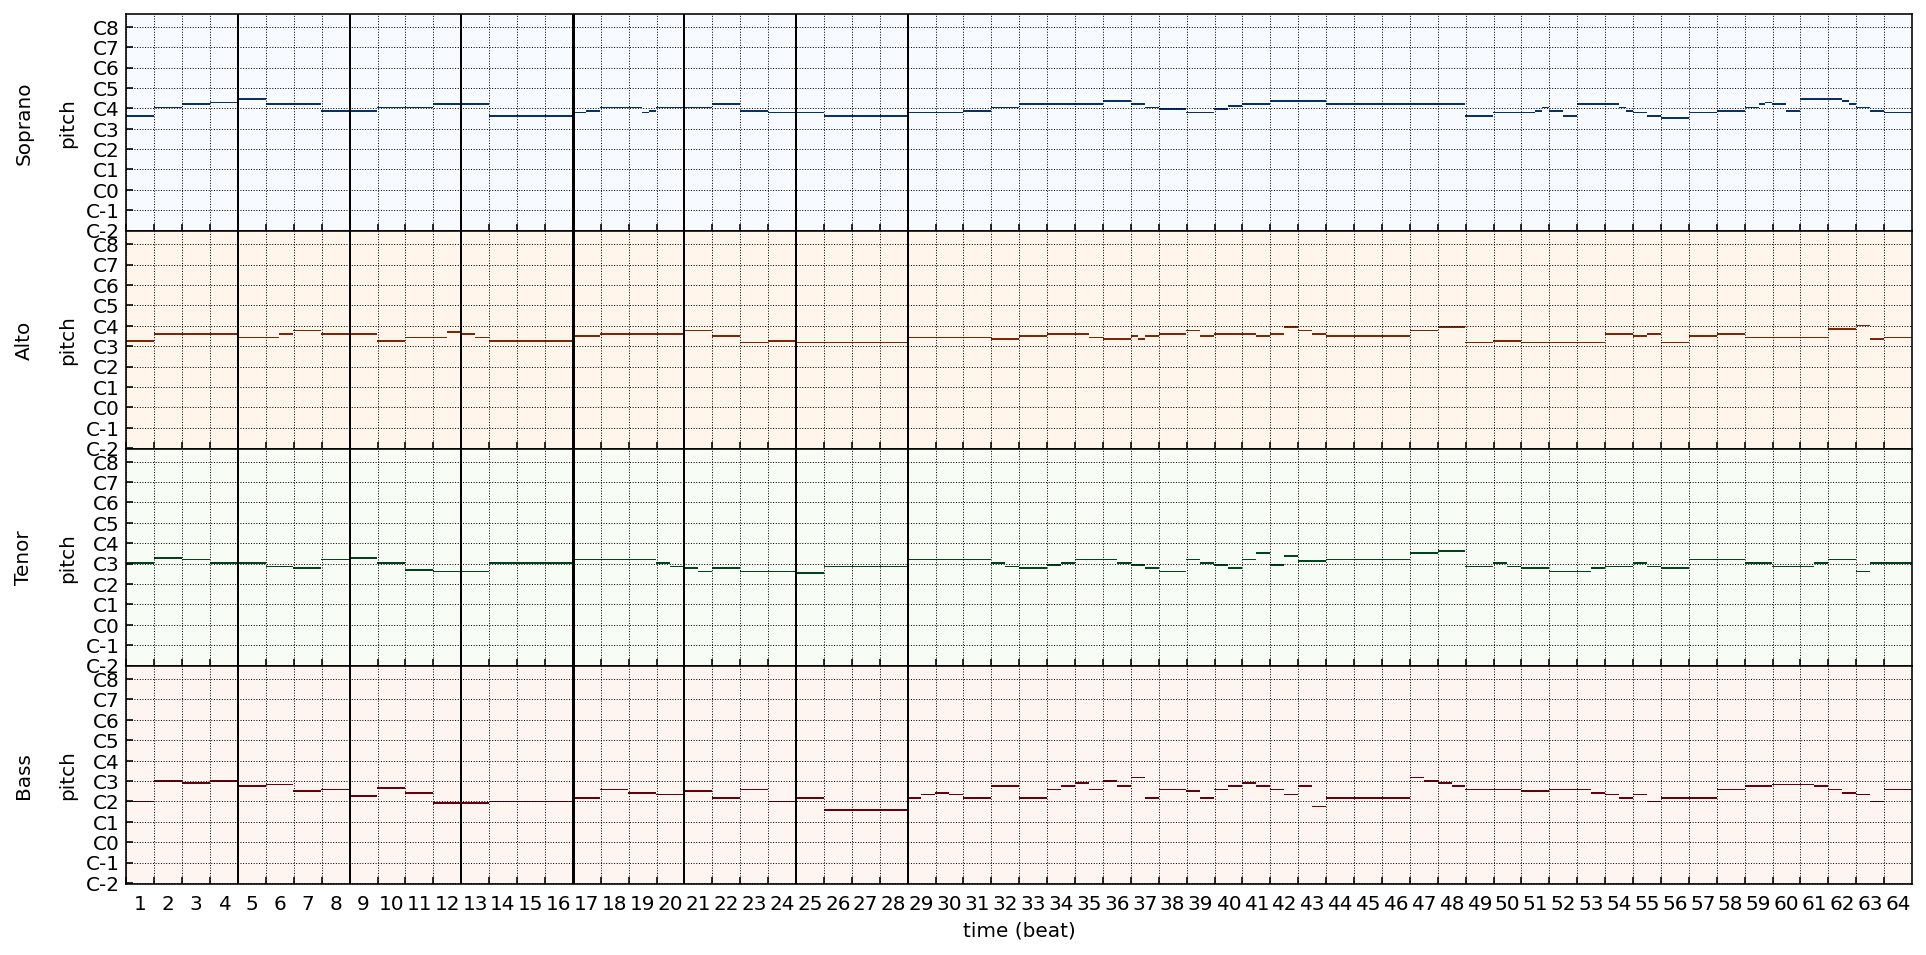

In [9]:
tracks = []
for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
    pianoroll = np.pad(
        np.concatenate(dataT[:4], 1)[idx], ((0, 0), (lowest_pitch, 128 - lowest_pitch - (n_pitches + 1))))
    tracks.append(pypianoroll.BinaryTrack(name=track_name, program=program, is_drum=is_drum, pianoroll=pianoroll))
multitrack = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(measure_resolution, 2 * 4 * measure_resolution, measure_resolution):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

In [10]:
dataT = torch.as_tensor(dataT, dtype=torch.float32)
dataset_ = torch.utils.data.TensorDataset(dataT)
data_loader = torch.utils.data.DataLoader(
    dataset_, batch_size=batch_size, drop_last=True, shuffle=True)

In [11]:
class GeneratorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.transconv = torch.nn.ConvTranspose3d(in_dim, out_dim, kernel, stride)
        self.batchnorm = torch.nn.BatchNorm3d(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.batchnorm(x)
        return torch.nn.functional.relu(x)

In [12]:
class Generator(torch.nn.Module):
    """A convolutional neural network (CNN) based generator. The generator takes
    as input a latent vector and outputs a fake sample."""
    def __init__(self):
        super().__init__()
        self.transconv0 = GeneratorBlock(latent_dim, 256, (4, 1, 1), (4, 1, 1))
        self.transconv1 = GeneratorBlock(256, 128, (1, 4, 1), (1, 4, 1))
        self.transconv2 = GeneratorBlock(128, 64, (1, 1, 4), (1, 1, 4))
        self.transconv3 = GeneratorBlock(64, 32, (1, 1, 3), (1, 1, 1))
        self.transconv4 = torch.nn.ModuleList([
            GeneratorBlock(32, 16, (1, 4, 1), (1, 4, 1))
            for _ in range(n_tracks)
        ])
        self.transconv5 = torch.nn.ModuleList([
            GeneratorBlock(16, 1, (1, 1, 14), (1, 1, 14))
            for _ in range(n_tracks)
        ])

    def forward(self, x):    
      x = x.view(-1, latent_dim, 1, 1, 1)
      x = self.transconv0(x)
      x = self.transconv1(x)
      x = self.transconv2(x)
      x = self.transconv3(x)
      x = [transconv(x) for transconv in self.transconv4]
      x = torch.cat([transconv(x_) for x_, transconv in zip(x, self.transconv5)], 1)
      x = x.view(-1, n_tracks, n_measures * measure_resolution, (n_pitches + 1))

      return x

In [13]:
class LayerNorm(torch.nn.Module):
    """An implementation of Layer normalization that does not require size
    information. Copied from https://github.com/pytorch/pytorch/issues/1959."""
    def __init__(self, n_features, eps=1e-5, affine=True):
        super().__init__()
        self.n_features = n_features
        self.affine = affine
        self.eps = eps
        if self.affine:
            self.gamma = torch.nn.Parameter(torch.Tensor(n_features).uniform_())
            self.beta = torch.nn.Parameter(torch.zeros(n_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)
        y = (x - mean) / (std + self.eps)
        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            y = self.gamma.view(*shape) * y + self.beta.view(*shape)
        return y

In [14]:
class DiscriminatorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.transconv = torch.nn.Conv3d(in_dim, out_dim, kernel, stride)
        self.layernorm = LayerNorm(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.layernorm(x)
        return torch.nn.functional.leaky_relu(x)

In [15]:
class Discriminator(torch.nn.Module):
    """A convolutional neural network (CNN) based discriminator. The
    discriminator takes as input either a real sample (in the training data) or
    a fake sample (generated by the generator) and outputs a scalar indicating
    its authentity.
    """
    def __init__(self):
        super().__init__()
        self.conv0 = torch.nn.ModuleList([
            DiscriminatorBlock(1, 16, (1, 1, 12), (1, 1, 12)) for _ in range(n_tracks)
        ])
        self.conv1 = torch.nn.ModuleList([
            DiscriminatorBlock(16, 16, (1, 4, 1), (1, 4, 1)) for _ in range(n_tracks)
        ])
        self.conv2 = DiscriminatorBlock(16 * 4, 64, (1, 1, 3), (1, 1, 1))
        self.conv3 = DiscriminatorBlock(64, 64, (1, 1, 4), (1, 1, 4))
        self.conv4 = DiscriminatorBlock(64, 128, (1, 4, 1), (1, 4, 1))
        self.conv5 = DiscriminatorBlock(128, 128, (2, 1, 1), (1, 1, 1))
        self.conv6 = DiscriminatorBlock(128, 256, (1, 1, 1), (3, 1, 1))
        self.dense = torch.nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(-1, n_tracks, n_measures, measure_resolution, (n_pitches +1))
        x = [conv(x[:, [i]]) for i, conv in enumerate(self.conv0)]
        x = torch.cat([conv(x_) for x_, conv in zip(x, self.conv1)], 1)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(-1, 256)
        x = self.dense(x)
        return x

In [16]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    """Compute the gradient penalty for regularization. Intuitively, the
    gradient penalty help stablize the magnitude of the gradients that the
    discriminator provides to the generator, and thus help stablize the training
    of the generator."""
    # Get random interpolations between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1)#.cuda()
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    interpolates = interpolates.requires_grad_(True)
    # Get the discriminator output for the interpolations
    d_interpolates = discriminator(interpolates)
    # Get gradients w.r.t. the interpolations
    fake = torch.ones(real_samples.size(0), 1)#.cuda()
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [17]:
def train_one_step(d_optimizer, g_optimizer, real_samples):
    """Train the networks for one step."""
    # Sample from the lantent distribution
    latent = torch.randn(batch_size, latent_dim)

    # Transfer data to GPU
    #if torch.cuda.is_available():
    real_samples = real_samples#.cuda()
    latent = latent#.cuda()

    # === Train the discriminator ===
    # Reset cached gradients to zero
    d_optimizer.zero_grad()
    # Get discriminator outputs for the real samples
    prediction_real = discriminator(real_samples)
    # Compute the loss function
    # d_loss_real = torch.mean(torch.nn.functional.relu(1. - prediction_real))
    d_loss_real = -torch.mean(prediction_real)
    # Backpropagate the gradients
    d_loss_real.backward()
    
    # Generate fake samples with the generator
    fake_samples = generator(latent)
    # Get discriminator outputs for the fake samples
    prediction_fake_d = discriminator(fake_samples.detach())
    # Compute the loss function
    # d_loss_fake = torch.mean(torch.nn.functional.relu(1. + prediction_fake_d))
    d_loss_fake = torch.mean(prediction_fake_d)
    # Backpropagate the gradients
    d_loss_fake.backward()

    # Compute gradient penalty
    gradient_penalty = 10.0 * compute_gradient_penalty(
        discriminator, real_samples.data, fake_samples.data)
    # Backpropagate the gradients
    gradient_penalty.backward()

    # Update the weights
    d_optimizer.step()
    
    # === Train the generator ===
    # Reset cached gradients to zero
    g_optimizer.zero_grad()
    # Get discriminator outputs for the fake samples
    prediction_fake_g = discriminator(fake_samples)
    # Compute the loss function
    g_loss = -torch.mean(prediction_fake_g)
    # Backpropagate the gradients
    g_loss.backward()
    # Update the weights
    g_optimizer.step()

    return d_loss_real + d_loss_fake, g_loss

In [18]:
# Create data loader
# data_loader = get_data_loader()

# Create neural networks
discriminator = Discriminator()
generator = Generator()
print("Number of parameters in G: {}".format(
    sum(p.numel() for p in generator.parameters() if p.requires_grad)))
print("Number of parameters in D: {}".format(
    sum(p.numel() for p in discriminator.parameters() if p.requires_grad)))

# Create optimizers
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.001,  betas=(0.5, 0.9))
g_optimizer = torch.optim.Adam(
    generator.parameters(), lr=0.001, betas=(0.5, 0.9))

# Prepare the inputs for the sampler, which wil run during the training
sample_latent = torch.randn(n_samples, latent_dim)

# Transfer the neural nets and samples to GPU
#if torch.cuda.is_available():
discriminator = discriminator#.cuda()
generator = generator#.cuda()
sample_latent = sample_latent#.cuda()

# Create an empty dictionary to store history samples
history_samples = {}

# Create a LiveLoss logger instance for monitoring
liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6,2))])

# Initialize step
step = 0

Number of parameters in G: 311788
Number of parameters in D: 134401


In [19]:
torch.cuda.is_available()

False

In [20]:
# Create a progress bar instance for monitoring
progress_bar = tqdm(total=n_steps, initial=step, ncols=80, mininterval=1)

# Start iterations
while step < n_steps + 1:
    # Iterate over the dataset
    for real_samples in data_loader:
        # Train the neural networks
        generator.train()
        d_loss, g_loss = train_one_step(d_optimizer, g_optimizer, real_samples[0])

        # Record smoothened loss values to LiveLoss logger
        if step > 0:
            running_d_loss = 0.05 * d_loss + 0.95 * running_d_loss
            running_g_loss = 0.05 * g_loss + 0.95 * running_g_loss
        else:
            running_d_loss, running_g_loss = 0.0, 0.0
        liveloss.update({'negative_critic_loss': -running_d_loss})
        # liveloss.update({'d_loss': running_d_loss, 'g_loss': running_g_loss})
        
        # Update losses to progress bar
        progress_bar.set_description_str(
            "(d_loss={: 8.6f}, g_loss={: 8.6f})".format(d_loss, g_loss))
        
        if step % sample_interval == 0:
            # Get generated samples
            generator.eval()
            samples = generator(sample_latent).cpu().detach().numpy()
            history_samples[step] = samples

            #Display loss curves
            #clear_output(True)
            #if step > 0:
              #liveloss.send()
            
            # Display generated samples
            samples = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, (n_pitches+1))
            tracks = []
            for idx, (program, is_drum, track_name) in enumerate(
                zip(programs, is_drums, track_names)
            ):
                pianoroll = np.pad(
                    samples[idx] > 0.5,
                    ((0, 0), (lowest_pitch, 128 - lowest_pitch - (n_pitches+1)))
                )
                tracks.append(
                    pypianoroll.BinaryTrack(
                        name=track_name,
                        program=program,
                        is_drum=is_drum,
                        pianoroll=pianoroll
                    )
                )
            m = Multitrack(
                tracks=tracks,
                tempo=tempo_array,
                resolution=beat_resolution
            )
            axs = m.plot()
            plt.gcf().set_size_inches((16, 8))
            for ax in axs:
                for x in range(
                    measure_resolution,
                    4 * measure_resolution * n_measures,
                    measure_resolution
                ):
                    if x % (measure_resolution * 4) == 0:
                        ax.axvline(x - 0.5, color='k')
                    else:
                        ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
            plt.show()
            
        step += 1
        progress_bar.update(1)
        if step >= n_steps:
            break

(d_loss=-0.034156, g_loss= 0.151086):   0%|            | 0/1000 [01:05<?, ?it/s]

Step=0


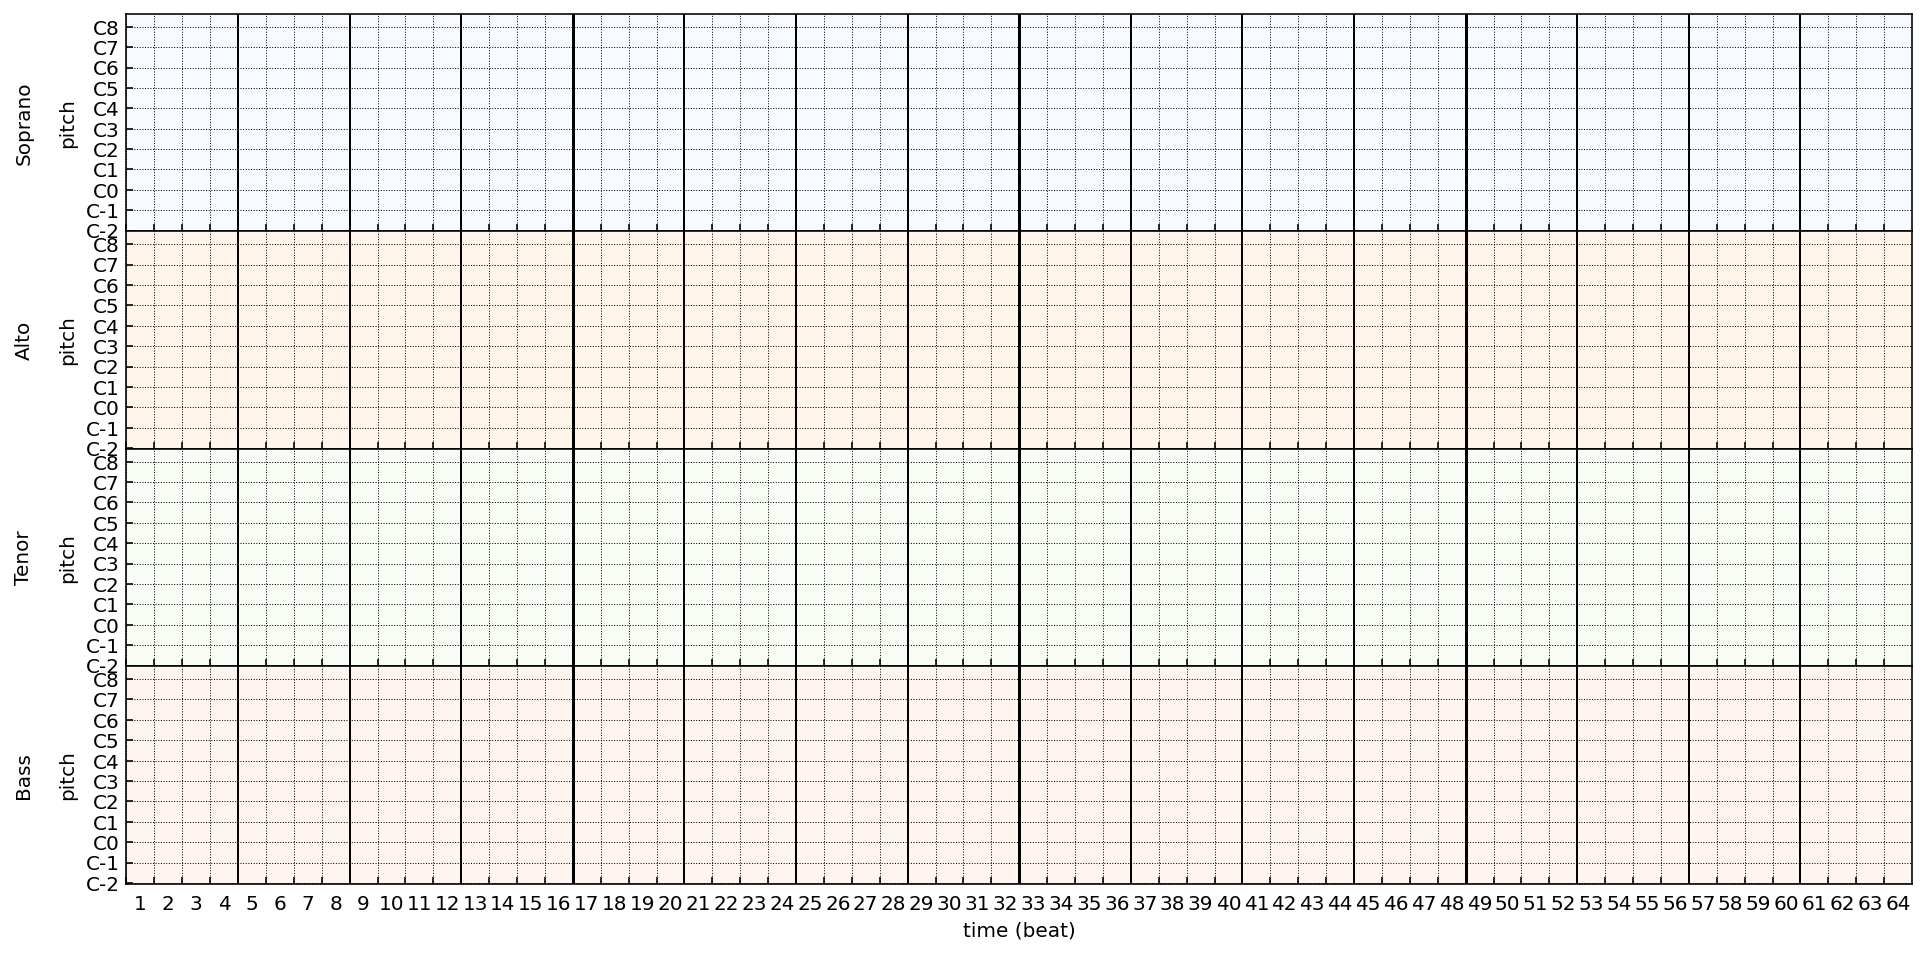

Multitrack(name=None, resolution=4, tempo=array(shape=(256, 1), dtype=float64), tracks=[BinaryTrack(name='Soprano', program=0, is_drum=False, pianoroll=array(shape=(256, 128), dtype=bool)), BinaryTrack(name='Alto', program=0, is_drum=False, pianoroll=array(shape=(256, 128), dtype=bool)), BinaryTrack(name='Tenor', program=0, is_drum=False, pianoroll=array(shape=(256, 128), dtype=bool)), BinaryTrack(name='Bass', program=0, is_drum=False, pianoroll=array(shape=(256, 128), dtype=bool))])
Step=10


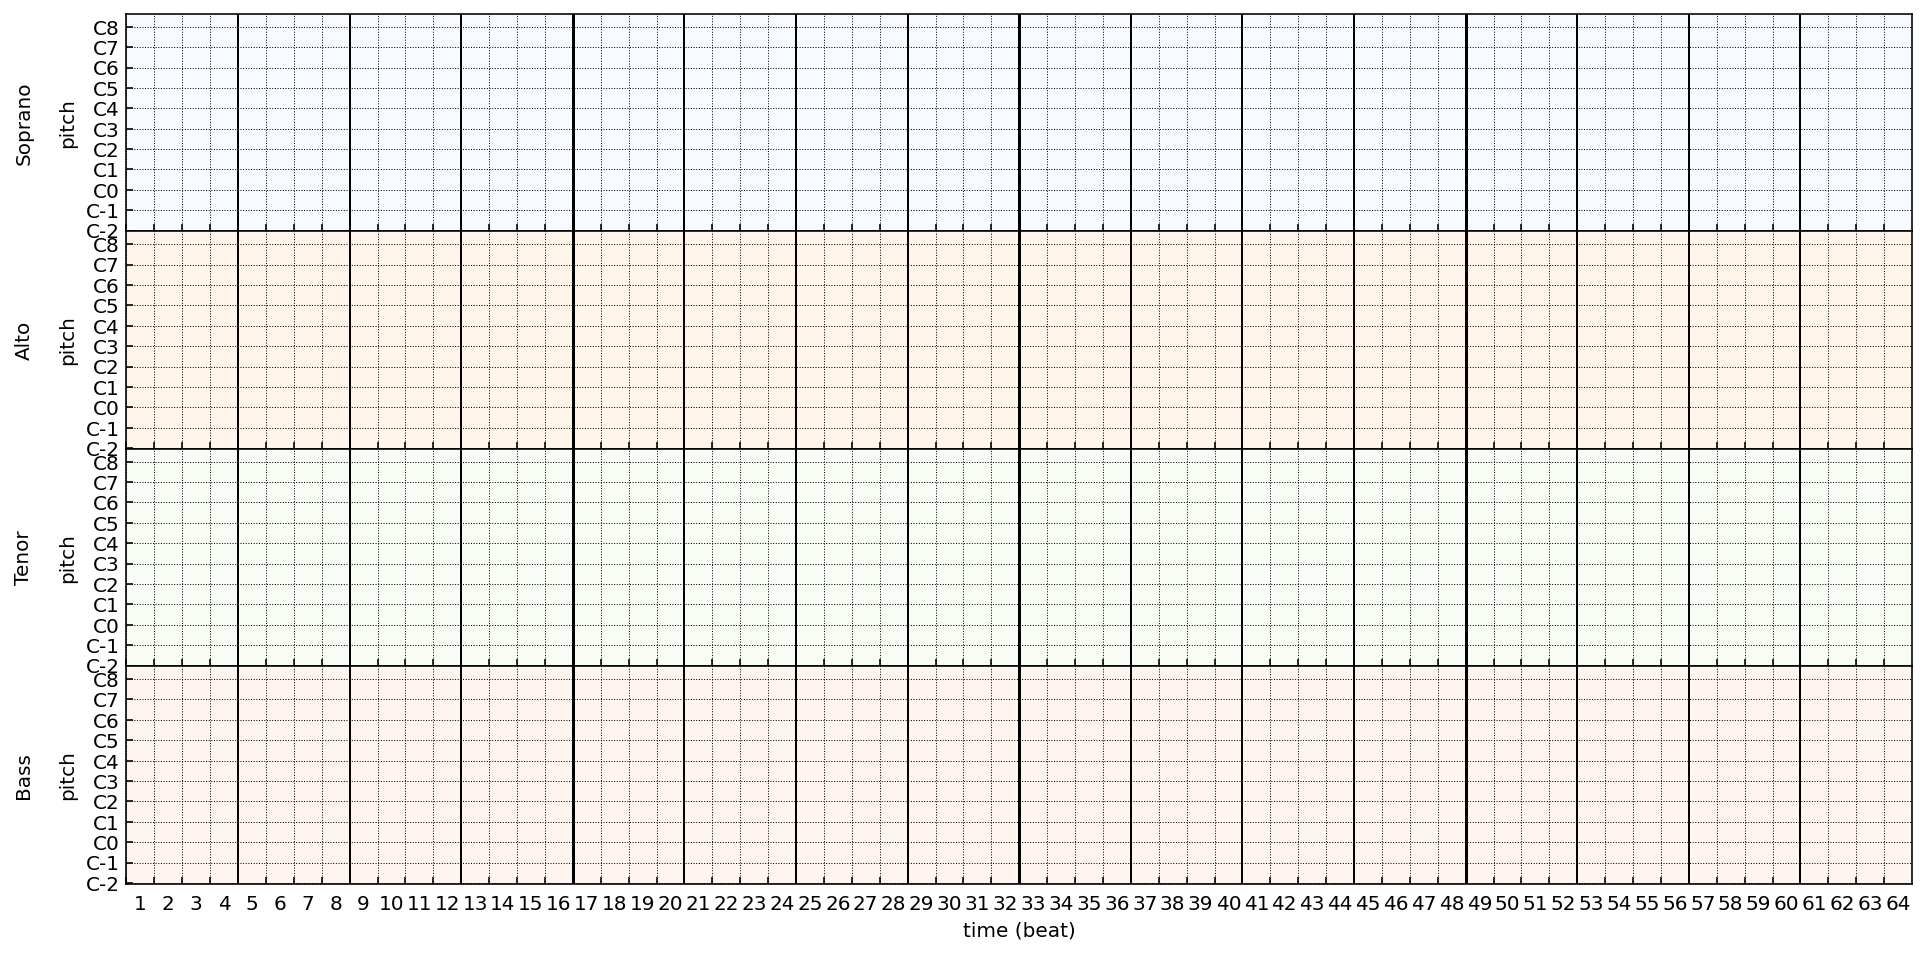

Multitrack(name=None, resolution=4, tempo=array(shape=(256, 1), dtype=float64), tracks=[BinaryTrack(name='Soprano', program=0, is_drum=False, pianoroll=array(shape=(256, 128), dtype=bool)), BinaryTrack(name='Alto', program=0, is_drum=False, pianoroll=array(shape=(256, 128), dtype=bool)), BinaryTrack(name='Tenor', program=0, is_drum=False, pianoroll=array(shape=(256, 128), dtype=bool)), BinaryTrack(name='Bass', program=0, is_drum=False, pianoroll=array(shape=(256, 128), dtype=bool))])
Step=100


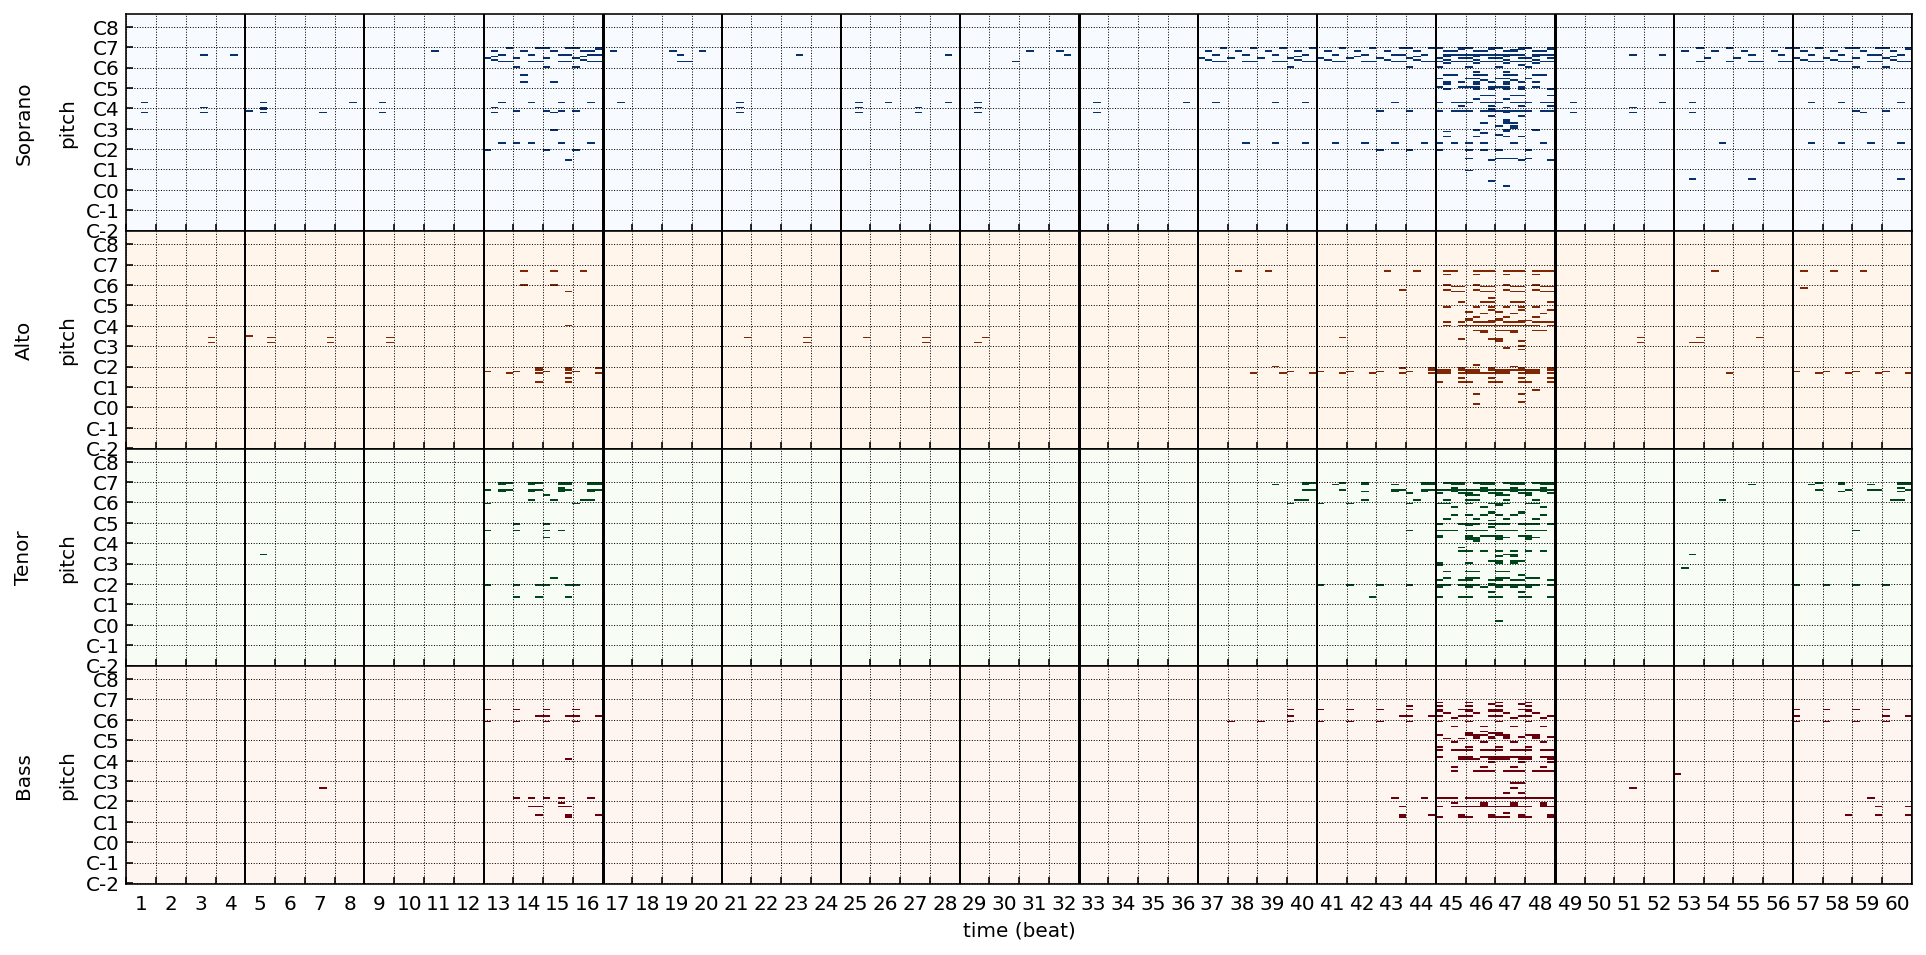

Multitrack(name=None, resolution=4, tempo=array(shape=(256, 1), dtype=float64), tracks=[BinaryTrack(name='Soprano', program=0, is_drum=False, pianoroll=array(shape=(256, 128), dtype=bool)), BinaryTrack(name='Alto', program=0, is_drum=False, pianoroll=array(shape=(240, 128), dtype=bool)), BinaryTrack(name='Tenor', program=0, is_drum=False, pianoroll=array(shape=(240, 128), dtype=bool)), BinaryTrack(name='Bass', program=0, is_drum=False, pianoroll=array(shape=(240, 128), dtype=bool))])
Step=1000


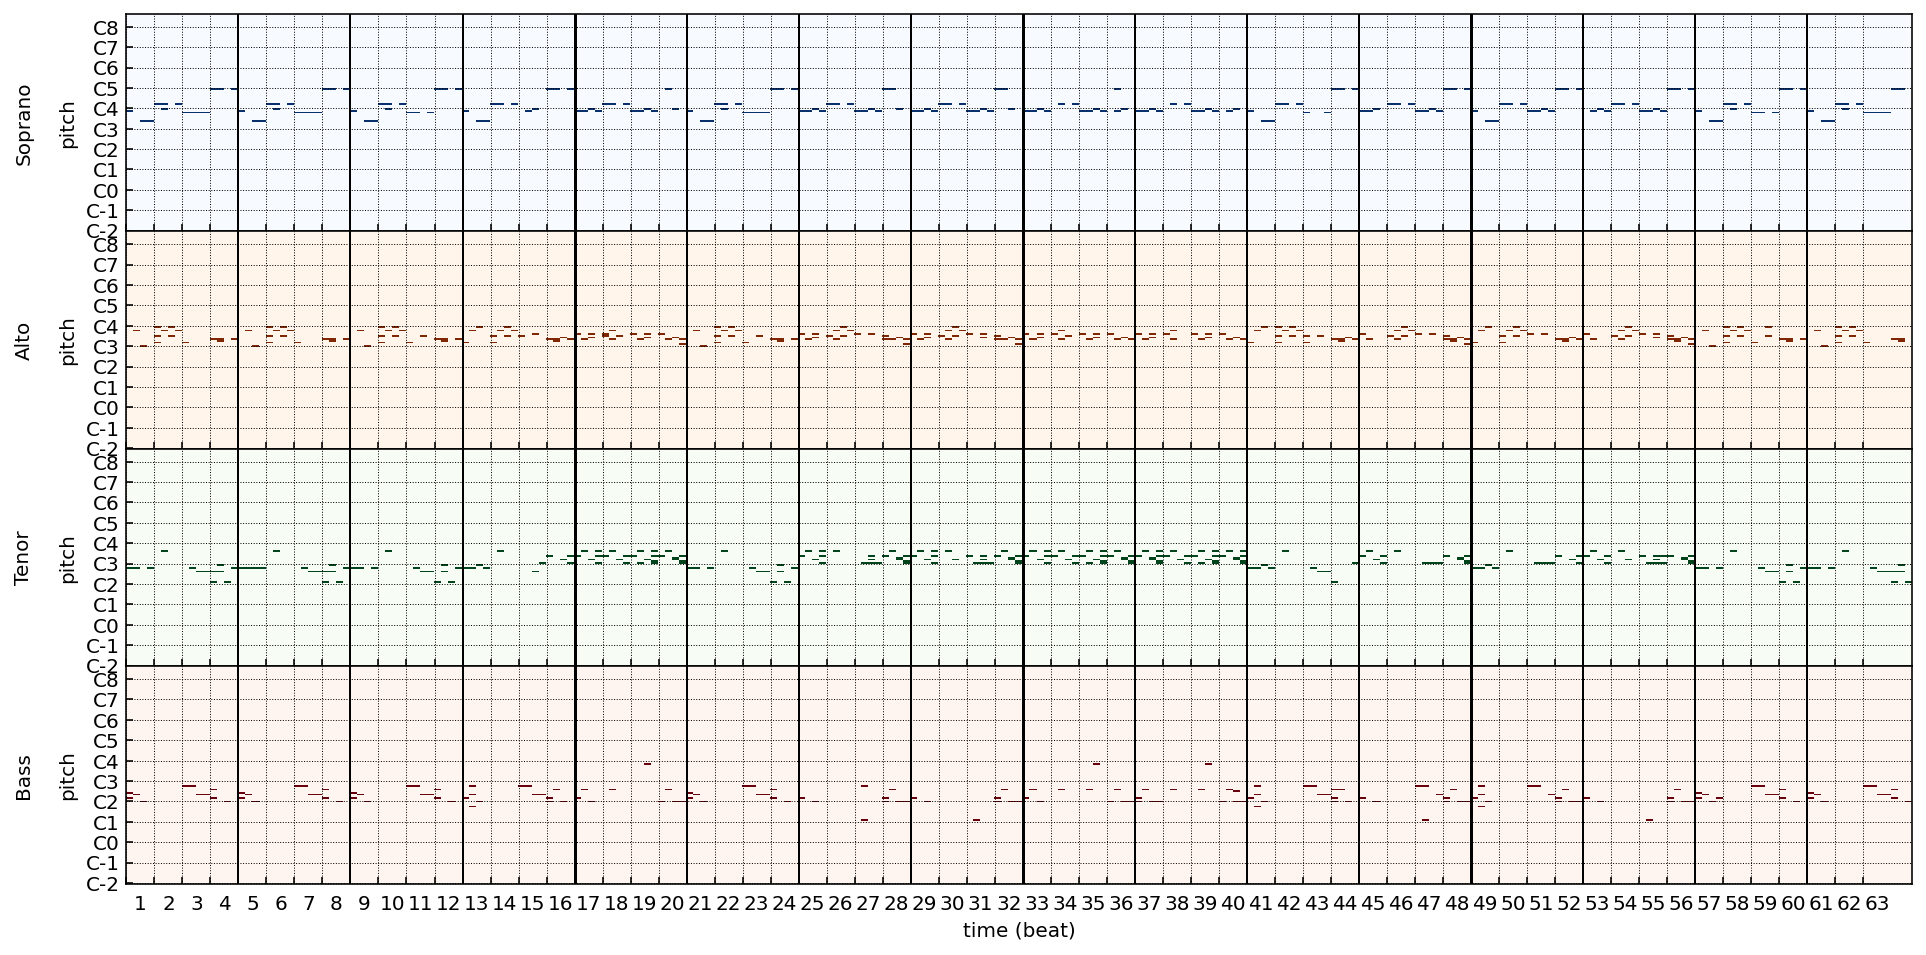

Multitrack(name=None, resolution=4, tempo=array(shape=(256, 1), dtype=float64), tracks=[BinaryTrack(name='Soprano', program=0, is_drum=False, pianoroll=array(shape=(256, 128), dtype=bool)), BinaryTrack(name='Alto', program=0, is_drum=False, pianoroll=array(shape=(256, 128), dtype=bool)), BinaryTrack(name='Tenor', program=0, is_drum=False, pianoroll=array(shape=(256, 128), dtype=bool)), BinaryTrack(name='Bass', program=0, is_drum=False, pianoroll=array(shape=(255, 128), dtype=bool))])
Step=1000


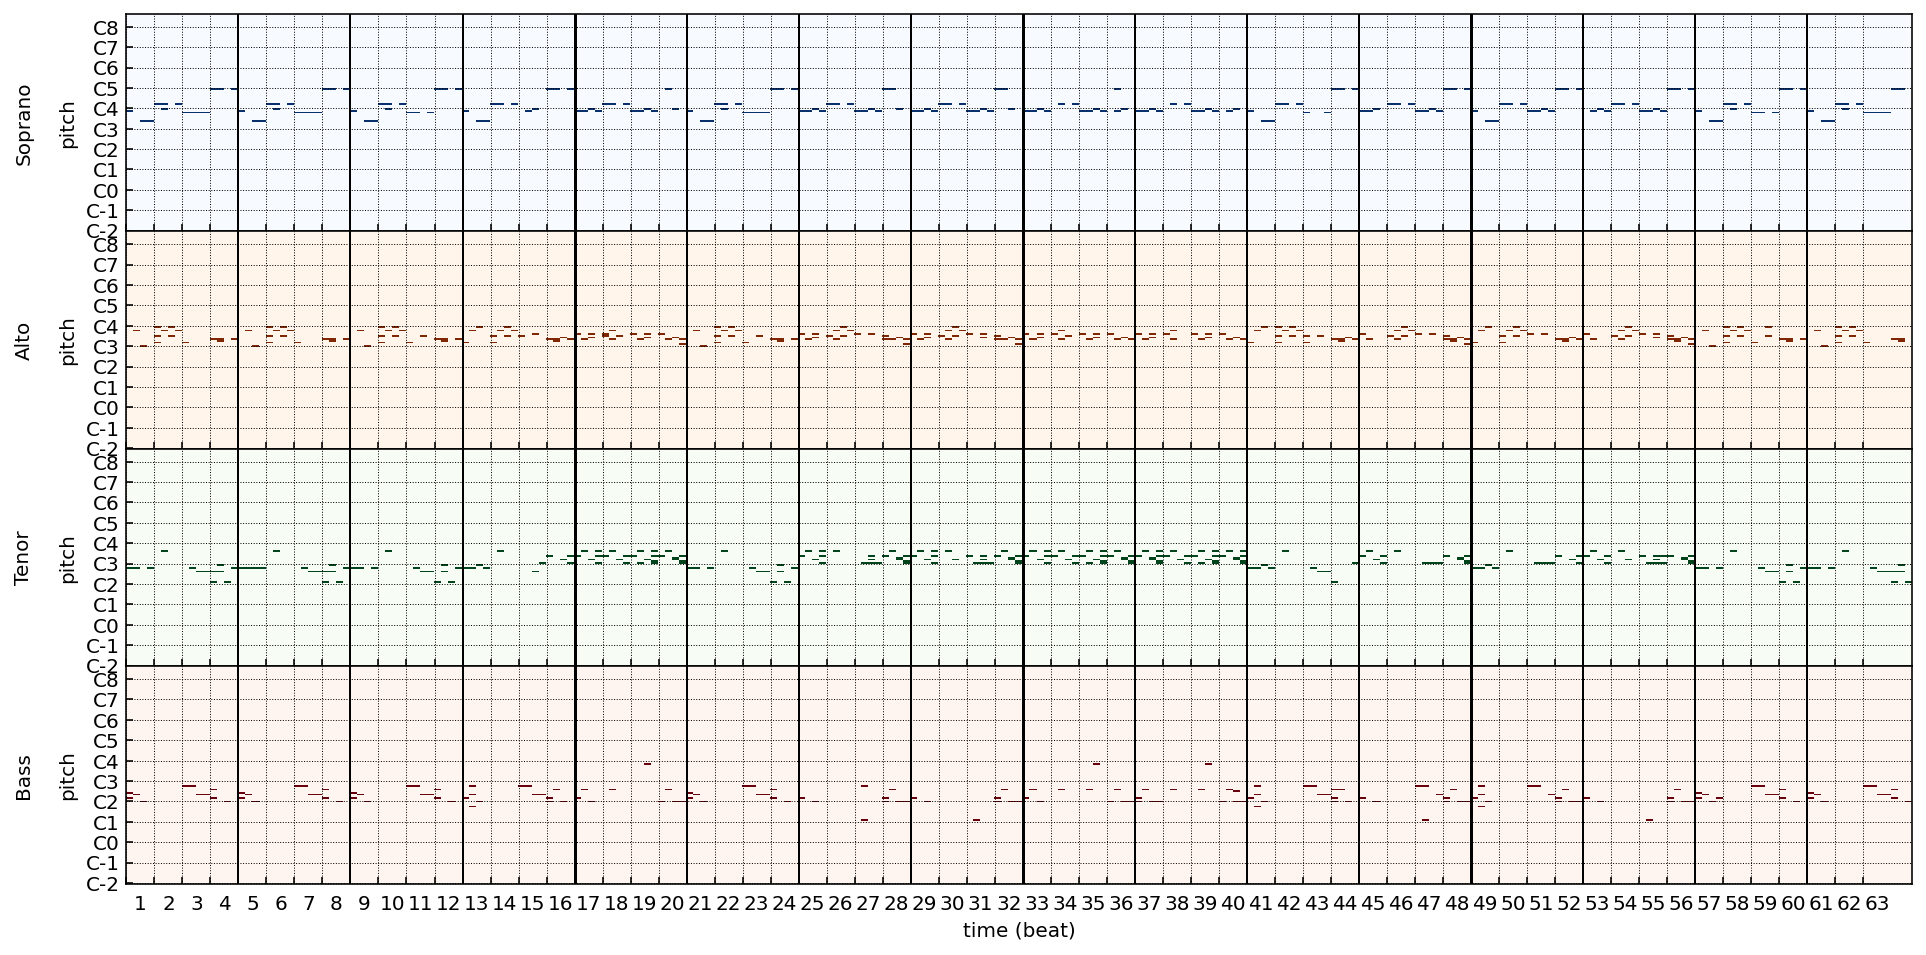

Multitrack(name=None, resolution=4, tempo=array(shape=(256, 1), dtype=float64), tracks=[BinaryTrack(name='Soprano', program=0, is_drum=False, pianoroll=array(shape=(256, 128), dtype=bool)), BinaryTrack(name='Alto', program=0, is_drum=False, pianoroll=array(shape=(256, 128), dtype=bool)), BinaryTrack(name='Tenor', program=0, is_drum=False, pianoroll=array(shape=(256, 128), dtype=bool)), BinaryTrack(name='Bass', program=0, is_drum=False, pianoroll=array(shape=(255, 128), dtype=bool))])


In [ ]:
# Show history
steps = [0, sample_interval, 10 * sample_interval, 100 * sample_interval, n_steps]
for step in steps:
    print(f"Step={step}")
    samples = history_samples[step].transpose(1, 0, 2, 3).reshape(n_tracks, -1, (n_pitches+1))
    tracks = []
    for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
        pianoroll = np.pad(
            samples[idx] > 0.5,
            ((0, 0), (lowest_pitch, 128 - lowest_pitch - (n_pitches+1)))
        )
        tracks.append(
            pypianoroll.BinaryTrack(
                name=track_name,
                program=program,
                is_drum=is_drum,
                pianoroll=pianoroll,
            )
        )
    
    #for track in tracks:
      #track.standardize()

      #print(track)

    #print(tracks)
    m = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
    
    m.binarize()
    m.set_resolution(beat_resolution)

    axs = m.plot()
    for ax in axs:
        for x in range(
            measure_resolution,
            4 * measure_resolution * n_measures,
            measure_resolution
        ):
            if x % (measure_resolution * 4) == 0:
                ax.axvline(x - 0.5, color='k')
            else:
                ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
    plt.gcf().set_size_inches((16, 8))
    plt.show()

    print(m)

m.write('./test.mid')

In [ ]:
s = history_samples[step].transpose(1, 0, 2, 3)
print(s.shape)
#for sample
#print(latent.shape)

(4, 4, 64, 84)


EVALUATION

In [ ]:
pianoroll = m.stack() > 0

ebr = pypianoroll.pitch_range(pianoroll)

print(ebr)


#def number_of_notes()

255
